# Evaluating clustering algorithms

The present library contains utilities for evaluating different clustering algorithms
(with or without ground truth labels). On top of the evaluation utilities there are classes for
performing parameters sweeps and model selection. Here we give an overview of the most important functionality


## Before running the notebook

Install the library and its dependencies with, if you haven't done so already
```
pip install -e .
```
from the root directory. You can also execute this command directly in the notebook but will need to reload the
kernel afterwards

In [1]:
# Note - this cell should be executed only once per session
%load_ext autoreload
%autoreload 2

import sys, os

# in order to get the config, it is not part of the library
os.chdir("..")
sys.path.append(os.path.abspath("."))

In [2]:
import numpy as np
import os
from pprint import pprint
from sklearn.cluster import DBSCAN
from hdbscan import HDBSCAN
import seaborn as sns
import geopandas as gp
import matplotlib.pyplot as plt
import logging

from sensai.clustering.coordinate_clustering import SKLearnCoordinateClustering
from sensai.hyperopt import GridSearch
from sensai.evaluation.evaluator_clustering import ClusteringModelSupervisedEvaluator, \
    ClusteringModelUnsupervisedEvaluator
from sensai.evaluation.eval_stats import ClusteringUnsupervisedEvalStats, ClusteringSupervisedEvalStats, \
    AdjustedMutualInfoScore
from sensai.evaluation.clustering_ground_truth import PolygonAnnotatedCoordinates

from config import get_config

logging.basicConfig(level=logging.INFO)

In [3]:
# loading data and config
c  = get_config(reload=True)
sampleFile = c.datafile_path("sample", stage=c.RAW) # this can point to a directory or a shp/geojson file
coordinatesDF = gp.read_file(sampleFile)

INFO:config.__Configuration:Reading configuration from /home/runner/work/sensAI/sensAI/config.json


## Evaluating a single model

For a single model that was already fitted, evaluation statistics can be extracted with `ClusteringEvalStats`, see the
example below (the eval_stats object can also be used to retrieve evaluation results one by one)


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 477 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.34s


{'CalinskiHarabaszScore': 189507.73108614382,
 'DaviesBouldinScore': 0.4281783403733455,
 'averageClusterSize': 57.36058700209644,
 'clusterSizeStd': 102.89757968842169,
 'maxClusterSize': 1983,
 'medianClusterSize': 34.0,
 'minClusterSize': 10,
 'noiseClusterSize': 51421,
 'numClusters': 477}


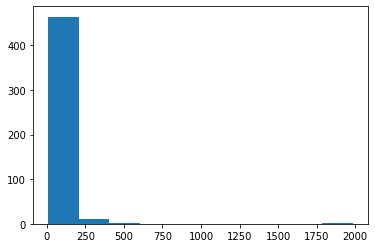

In [4]:
dbscan = SKLearnCoordinateClustering(DBSCAN(eps=150, min_samples=20))
dbscan.fit(coordinatesDF)
evalStats = ClusteringUnsupervisedEvalStats.fromModel(dbscan)
pprint(evalStats.getAll())
plt.hist(evalStats.clusterSizeDistribution)
plt.show()

## Model selection

For model selection we need to compare different (or differently parametrized) models that were
trained on the same dataset. The `ClusteringEvaluator` abstraction was designed with this goal in mind.
The evaluator can be used to obtain evaluation statistics for different models that are guaranteed
to be comparable with each other (always computed by the same object in the same way). Here an example comparing
hdbscan and dbscan performances

In [5]:
hdbscan = SKLearnCoordinateClustering(HDBSCAN(min_cluster_size=100, min_samples=20, cluster_selection_epsilon=150))

modelEvaluator = ClusteringModelUnsupervisedEvaluator(coordinatesDF)

dbscanEvalStats = modelEvaluator.evalModel(dbscan, fit=False)  # dbscan was already fitted on this data
hdbscanEvalStats = modelEvaluator.evalModel(hdbscan)


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 134 clusters


In [6]:
print("dbscan_performance: \n")
pprint(dbscanEvalStats.getAll())
print("")
print("hdbscan_performance: \n")
pprint(hdbscanEvalStats.getAll())

dbscan_performance: 



INFO:sensai.util.tracking:Finished execution of getAll in 0.45s


{'CalinskiHarabaszScore': 189507.73108614382,
 'DaviesBouldinScore': 0.4281783403733455,
 'averageClusterSize': 57.36058700209644,
 'clusterSizeStd': 102.89757968842169,
 'maxClusterSize': 1983,
 'medianClusterSize': 34.0,
 'minClusterSize': 10,
 'noiseClusterSize': 51421,
 'numClusters': 477}

hdbscan_performance: 



INFO:sensai.util.tracking:Finished execution of getAll in 0.30s


{'CalinskiHarabaszScore': 12813.60750355356,
 'DaviesBouldinScore': 0.8143041883077772,
 'averageClusterSize': 473.13432835820896,
 'clusterSizeStd': 1071.7603234450864,
 'maxClusterSize': 10226,
 'medianClusterSize': 231.0,
 'minClusterSize': 101,
 'noiseClusterSize': 15382,
 'numClusters': 134}


One of the main purposes of evaluators is to be used within classes that perform a parameter sweep, e.g.
a `GridSearch`. All such objects return a data frame and (optionally but recommended!) persist all evaluation results
in a csv.

In [7]:
parameterOptions = {
    "min_samples": [10, 20],
    "eps": [50, 150]
}

# for running the grid search in multiple processes, all objects need to be picklable.
# Therefore we pass a named function as model factory instead of a lambda
def dbscanFactory(**kwargs):
    return SKLearnCoordinateClustering(DBSCAN(**kwargs))

dbscanGridSearch = GridSearch(dbscanFactory, parameterOptions, csvResultsPath=os.path.join(c.temp, "dbscanGridSearchCsv"))

INFO:sensai.hyperopt:Created GridSearch object for 4 parameter combinations


In [8]:
# the results of the grid-search are saved as csv under the path provided above
resultDf = dbscanGridSearch.run(modelEvaluator, sortColumnName="numClusters", ascending=False)
resultDf.head()

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 10, 'eps': 50}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 234 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.09s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 8.30s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  CalinskiHarabaszScore  DaviesBouldinScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples eps
0         234          438386.535007            0.293545           36.012821       90.293419           1288              7               17.0            70355  SKLearnCoordinateClustering          10  50


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 10, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 1057 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.77s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 7.25s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  CalinskiHarabaszScore  DaviesBouldinScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0        1057           28889.286349            0.602208           56.362346      134.804446           2135              4               22.0            19207  SKLearnCoordinateClustering          10  150
1         234          438386.535007            0.293545           36.012821       90.293419           1288              7               17.0            70355  SKLearnCoordinateClustering          10   50


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 50}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 36 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.01s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 6.22s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  CalinskiHarabaszScore  DaviesBouldinScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0        1057           2.888929e+04            0.602208           56.362346      134.804446           2135              4               22.0            19207  SKLearnCoordinateClustering          10  150
1         234           4.383865e+05            0.293545           36.012821       90.293419           1288              7               17.0            70355  SKLearnCoordinateClustering          10   50
2          36           1.646224e+06            0.278540           65.777778       97.948998            568             20               34.0            76414  SKLearnCoordinateClustering          20   50


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 477 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.24s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 6.56s


INFO:sensai.hyperopt:Updated grid search result:
  numClusters  CalinskiHarabaszScore  DaviesBouldinScore  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0        1057           2.888929e+04            0.602208           56.362346      134.804446           2135              4               22.0            19207  SKLearnCoordinateClustering          10  150
1         477           1.895077e+05            0.428178           57.360587      102.897580           1983             10               34.0            51421  SKLearnCoordinateClustering          20  150
2         234           4.383865e+05            0.293545           36.012821       90.293419           1288              7               17.0            70355  SKLearnCoordinateClustering          10   50
3          36           1.646224e+06            0.278540           65.777778       97.948998            568             20         

,numClusters,CalinskiHarabaszScore,DaviesBouldinScore,averageClusterSize,clusterSizeStd,maxClusterSize,minClusterSize,medianClusterSize,noiseClusterSize,str(model),min_samples,eps
0,1057,2.888929e+04,0.602208,56.362346,134.804446,2135,4,22.0,19207,SKLearnCoordinateClustering,10,150
1,477,1.895077e+05,0.428178,57.360587,102.897580,1983,10,34.0,51421,SKLearnCoordinateClustering,20,150
2,234,4.383865e+05,0.293545,36.012821,90.293419,1288,7,17.0,70355,SKLearnCoordinateClustering,10,50
3,36,1.646224e+06,0.278540,65.777778,97.948998,568,20,34.0,76414,SKLearnCoordinateClustering,20,50


The resulting data frame can be used to visualize the results through standard techniques,
e.g. pivoting and heatmaps


calinskiHarabaszScores


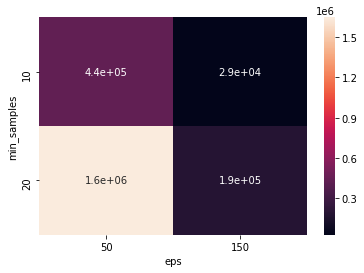

In [9]:
print("calinskiHarabaszScores")
chScoreHeatmap = resultDf.pivot(index="min_samples", columns="eps", values="CalinskiHarabaszScore")
sns.heatmap(chScoreHeatmap, annot=True)
plt.show()

daviesBouldinScores


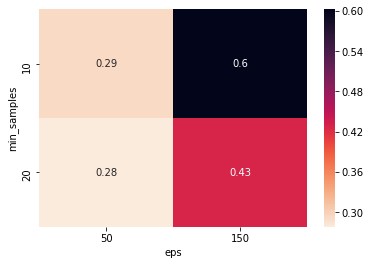

In [10]:
print("daviesBouldinScores")
chScoreHeatmap = resultDf.pivot(index="min_samples", columns="eps", values="DaviesBouldinScore")
sns.heatmap(chScoreHeatmap, cmap=sns.cm.rocket_r, annot=True)
plt.show()

numClusters


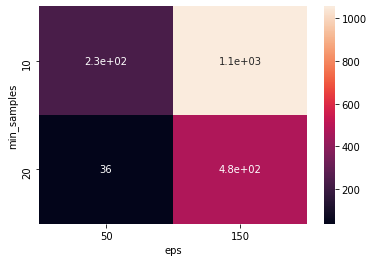

In [11]:
print("numClusters")
numClustersHeatmap = resultDf.pivot(index="min_samples", columns="eps", values="numClusters").astype(int)
sns.heatmap(numClustersHeatmap, annot=True)  # something goes wrong with the datatype here, maybe b/c of zero clusters
plt.show()

## Dealing with ground truth labels


The evaluation classes can take ground truth labels for all coordinates and use them for calculating related metrics.
However, such labels are typically hard to come by, especially if the coordinates cover a large area. Therefore the
library includes utilities for extracting labels from ground truth provided in form of __cluster polygons in a selected
region__. The central class for dealing with this kind of data is `ground_truth.PolygonAnnotatedCoordinates`,
see examples below.

In [12]:
# The polygons can be read directly from a file, see the documentation for more details
groundTruthClusters = PolygonAnnotatedCoordinates(coordinatesDF, c.datafile_path("sample", stage=c.GROUND_TRUTH))

As usual, the object has methods for plotting and exporting to geodata frames.
These can be very useful for inspecting the provided data

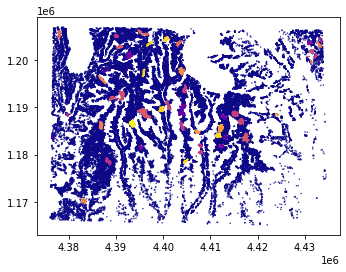

,geometry
identifier,
-1,"MULTIPOINT (4376132.864 1166694.757, 4376133.7..."
0,"MULTIPOINT (4407503.519 1182004.668, 4407516.7..."
1,"MULTIPOINT (4377765.260 1205034.312, 4377779.2..."
2,"MULTIPOINT (4379552.328 1188520.932, 4379560.1..."
3,"MULTIPOINT (4376405.982 1183903.847, 4376421.3..."


In [13]:
groundTruthClusters.plot(markersize=0.2, cmap="plasma")
plt.show()

groundTruthClusters.toGeoDF().head()

We can extract the coordinates and labels for the annotated region and use them in evaluation. In the following
we will train our own adaption of DBSCAN, namely `boundedDBSCAN` on datapoints in the ground truth region and
evaluate the results against the true labels

In [14]:
boundedDbscan = SKLearnCoordinateClustering(DBSCAN(eps=150, min_samples=20), minClusterSize=100)
groundTruthCoordinates, groundTruthLabels = groundTruthClusters.getCoordinatesLabels()
supervisedEvaluator = ClusteringModelSupervisedEvaluator(groundTruthCoordinates, trueLabels=groundTruthLabels)
supervisedEvalStats = supervisedEvaluator.evalModel(boundedDbscan)

print("Supervised evaluation metrics of bounded dbscan:")
pprint(supervisedEvalStats.getAll())

INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 57 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.09s


Supervised evaluation metrics of bounded dbscan:
{'AdjustedMutualInfoScore': 0.6497595011750351,
 'AdjustedRandScore': 0.17987036763356976,
 'FowlkesMallowsScore': 0.27503572733470316,
 'VMeasureScore': 0.661727751698087,
 'averageClusterSize': 197.94736842105263,
 'clusterSizeStd': 252.18173765930052,
 'maxClusterSize': 1983,
 'medianClusterSize': 132.0,
 'minClusterSize': 100,
 'noiseClusterSize': 67499,
 'numClusters': 57}


In [15]:
print("Unsupervised evaluation metrics of bounded dbscan:")
pprint(ClusteringUnsupervisedEvalStats(groundTruthCoordinates, groundTruthLabels).getAll())
print("")
print("Unsupervised evaluation metrics of annotated data")
pprint(ClusteringUnsupervisedEvalStats.fromModel(boundedDbscan).getAll())

INFO:sensai.util.tracking:Finished execution of getAll in 0.02s


INFO:sensai.util.tracking:Finished execution of getAll in 0.03s


Unsupervised evaluation metrics of bounded dbscan:
{'CalinskiHarabaszScore': 196718.30364210886,
 'DaviesBouldinScore': 0.2807623964112674,
 'averageClusterSize': 179.5744680851064,
 'clusterSizeStd': 98.98522234019755,
 'maxClusterSize': 499,
 'medianClusterSize': 143.0,
 'minClusterSize': 29,
 'noiseClusterSize': 70342,
 'numClusters': 47}

Unsupervised evaluation metrics of annotated data
{'CalinskiHarabaszScore': 313728.9671149488,
 'DaviesBouldinScore': 0.248334574556368,
 'averageClusterSize': 197.94736842105263,
 'clusterSizeStd': 252.18173765930052,
 'maxClusterSize': 1983,
 'medianClusterSize': 132.0,
 'minClusterSize': 100,
 'noiseClusterSize': 67499,
 'numClusters': 57}


The bounded dbscan is performing quite OK with the given parameters, although we see that it segregates clusters too
much and has a general tendency towards smaller clusters. These tendencies can be seen visually by comparing the ground
truth and the bounded dbscan cluster plots

INFO:sensai.clustering.base.clustering:Processed 0% of clusters


INFO:sensai.clustering.base.clustering:Processed 5% of clusters


INFO:sensai.clustering.base.clustering:Processed 10% of clusters


INFO:sensai.clustering.base.clustering:Processed 15% of clusters


INFO:sensai.util.tracking:Finished execution of toGeoDF in 1.59s


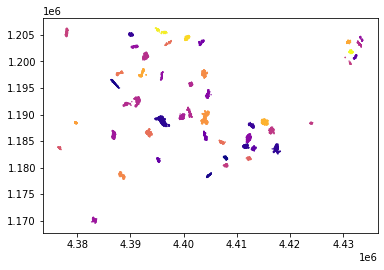

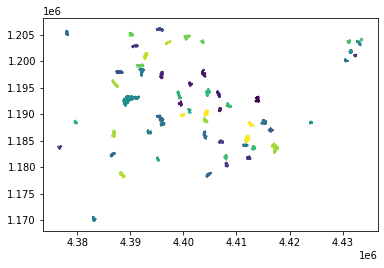

In [16]:
groundTruthClusters.plot(markersize=0.2, cmap="plasma", includeNoise=False)

boundedDbscan.plot(markersize=0.2, includeNoise=False)

## Supervised parameter estimation

We can now bring everything together by running a grid search and evaluating against ground truth. Very little code
is needed for that, so we will write it entirely in the cell below

In [17]:
parameterOptions = {
    "min_samples": [19, 20, 21],
    "eps": [140, 150, 160]
}

supervisedGridSearch = GridSearch(dbscanFactory, parameterOptions,
                                           csvResultsPath=os.path.join(c.temp, "bounded_dbscan_grid_search.csv"))

INFO:sensai.hyperopt:Created GridSearch object for 9 parameter combinations


In [18]:
# we will sort the results by mutual information store
supervisedResultDf = supervisedGridSearch.run(supervisedEvaluator, sortColumnName=AdjustedMutualInfoScore.name,
                                              ascending=False)
supervisedResultDf

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 19, 'eps': 140}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 462 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.31s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.01s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 19, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 530 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.37s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.18s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140
1                 0.305778       0.359296             0.082667           0.003835         530           56.394340      100.174928           1988             14               33.0            48893  SKLearnCoordinateClustering          19  150


INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 19, 'eps': 160}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 569 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.41s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.15s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140
1                 0.305778       0.359296             0.082667           0.003835         530           56.394340      100.174928           1988             14               33.0            48893  SKLearnCoordinateClustering          19  150
2                 0.275955       0.326911             0.077053           0.002975         569           61.312830      103.038054           2023             12               36.0            43895  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 140}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 406 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.28s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 0.97s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
1                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140
2                 0.305778       0.359296             0.082667           0.003835         530           56.394340      100.174928           1988             14               33.0            48893  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 477 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.35s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.07s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
1                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140
2                 0.325457       0.378548             0.087130           0.004546         477           57.360587      102.897111           1983             10               34.0            51421  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 20, 'eps': 160}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 528 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.37s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.09s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
1                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering          19  140
2                 0.325457       0.378548             0.087130           0.004546         477           57.360587      102.897111           1983             10               34.0            51421  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 21, 'eps': 140}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 356 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.25s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 0.94s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.382680       0.433131             0.099087           0.004253         356           57.724719      114.153418           1958              8               33.0            58232  SKLearnCoordinateClustering          21  140
1                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
2                 0.337171       0.391642             0.088137           0.003466         462           53.848485      102.862824           1966              7               32.0            53904  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 21, 'eps': 150}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 433 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.30s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.09s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.382680       0.433131             0.099087           0.004253         356           57.724719      114.153418           1958              8               33.0            58232  SKLearnCoordinateClustering          21  140
1                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
2                 0.344340       0.396441             0.091865           0.005319         433           58.344111      106.779193           1980             12               34.0            53519  SKLearnCoordinateClustering 

INFO:sensai.hyperopt.GridSearch:Evaluating {'min_samples': 21, 'eps': 160}


INFO:sensai.clustering.base.clustering:Fitting SKLearnCoordinateClustering to 78782 coordinate datapoints.


INFO:sensai.clustering.base.clustering:SKLearnCoordinateClustering found 481 clusters


INFO:sensai.util.tracking:Finished execution of getAll in 0.38s


INFO:sensai.util.tracking:Finished execution of _computeMetrics in 1.11s


INFO:sensai.hyperopt:Updated grid search result:
   AdjustedMutualInfoScore  VMeasureScore  FowlkesMallowsScore  AdjustedRandScore numClusters  averageClusterSize  clusterSizeStd maxClusterSize minClusterSize  medianClusterSize noiseClusterSize                   str(model) min_samples  eps
0                 0.382680       0.433131             0.099087           0.004253         356           57.724719      114.153418           1958              8               33.0            58232  SKLearnCoordinateClustering          21  140
1                 0.359844       0.412557             0.094061           0.004357         406           55.945813      108.367133           1965             14               32.5            56068  SKLearnCoordinateClustering          20  140
2                 0.344340       0.396441             0.091865           0.005319         433           58.344111      106.779193           1980             12               34.0            53519  SKLearnCoordinateClustering 

,AdjustedMutualInfoScore,VMeasureScore,FowlkesMallowsScore,AdjustedRandScore,numClusters,averageClusterSize,clusterSizeStd,maxClusterSize,minClusterSize,medianClusterSize,noiseClusterSize,str(model),min_samples,eps
0,0.382680,0.433131,0.099087,0.004253,356,57.724719,114.153418,1958,8,33.0,58232,SKLearnCoordinateClustering,21,140
1,0.359844,0.412557,0.094061,0.004357,406,55.945813,108.367133,1965,14,32.5,56068,SKLearnCoordinateClustering,20,140
2,0.344340,0.396441,0.091865,0.005319,433,58.344111,106.779193,1980,12,34.0,53519,SKLearnCoordinateClustering,21,150
3,0.337171,0.391642,0.088137,0.003466,462,53.848485,102.862824,1966,7,32.0,53904,SKLearnCoordinateClustering,19,140
4,0.325457,0.378548,0.087130,0.004546,477,57.360587,102.897111,1983,10,34.0,51421,SKLearnCoordinateClustering,20,150
5,0.314100,0.364825,0.085829,0.004605,481,62.022869,105.878767,2005,12,37.0,48949,SKLearnCoordinateClustering,21,160
6,0.305778,0.359296,0.082667,0.003835,530,56.394340,100.174928,1988,14,33.0,48893,SKLearnCoordinateClustering,19,150
7,0.294439,0.345625,0.081099,0.003768,528,61.195076,103.120378,2006,12,37.0,46471,SKLearnCoordinateClustering,20,160
8,0.275955,0.326911,0.077053,0.002975,569,61.312830,103.038054,2023,12,36.0,43895,SKLearnCoordinateClustering,19,160


It seems like we were lucky to already have picked the optimal parameters for the dbscan above.
It is also interesting to notice that the supervised scores are in
stark disagreement with the unsupervised ones